In [3]:
#Chargement des librairies

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import offsetbox
import cv2
import os,glob
import matplotlib.pylab as plt
from os import listdir,makedirs
from os.path import isfile,join
import PIL
import re
from keras.utils import to_categorical

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn import preprocessing

import numpy as np
from scipy import signal

%matplotlib inline

In [5]:


# Chargement des données
y = pd.read_csv("C:/Users/data/Y_train_CVw08PX.csv")
X = pd.read_csv("C:/Users/data/X_train_update.csv")

# transformer les images du dossier en numpyarray, avec une période de n_b_image_select 
#pth ='C:/Users/image_train'
# dossier des images compressées et redimentionnées
pth = 'C:/Users/MBACHKAT/Anaconda3/Data/image_reduction2/'

folders =  os.listdir(pth)



files = []
columns = ['data']
# variables qui nous donne le nombre de la période de selection des images, exemple si egale à 20 alors on garde les images toutes les 100 images
nb_images_select = 20
# commpteur de fichier
cpt = 0
# regex du nom de fichier, on recupère le numéro de l'image
r = re.compile(r"image_([0-9]*)_product")

# taille de l'image
pixel_size = 150

for file in folders:
    # on selectionne une image toutes les nb_images_select images
    if(cpt%nb_images_select==0):
        files.append(file)
    cpt+=1

#  initialisation de ligne du numpy array
samples = np.ones(shape=(1+3*pixel_size*pixel_size))
for file in files:
    # on récupère l'image du fichier
    img = cv2.imread(os.path.join(pth,file))
    img = np.int64(img)
    # on écrase l'image
    img = img.reshape(-1)
    # recherche du pattern dans le nom du fichier
    r_num_file = r.search(file)
    # numéro de l'image
    num_file = r_num_file.groups()[0]
    
    img_class = y.loc[X.loc[X['imageid'].astype(str)== str(num_file)].index[0],'prdtypecode']
    # ligne du numpy array avec les pixels comme colonne et on rajoute une colonne pour le type produit
    img_tab = np.append(img,img_class)
    # on empile les lignes
    samples = np.vstack((samples, img_tab))
   
array_image = samples

# effacer la première ligne qui a servi en remplire l'array transformé en dataframe

array_image = np.delete(array_image,0,0)



In [7]:
# On vérifie les dimensions des numpy array


targets = array_image[:,-1]

df_image = array_image[:,0:3*pixel_size*pixel_size]

print(targets.shape)

print(df_image.shape)

(4246,)
(4246, 67500)


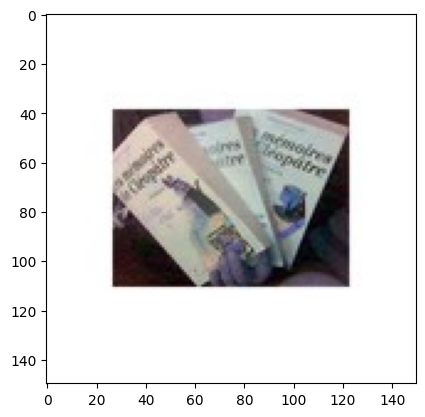

In [8]:
X = np.array(df_image)
X = X.reshape((-1, 150, 150, 3))
X = X.astype('float32')
X /= 255.0

Y = np.array(targets)

X.shape

plt.imshow(X[2])
plt.savefig('pictureXg.jpg')

In [9]:
Mcontour = [[1,0,0],[0,0,0],[0,0,-1]]
Mclair = [[1,0,0],[0,0,0],[0,0,10]]

Xprim = X
Xsecond = X

for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        Xprim[i,:,j] = signal.convolve2d(X[i,:,j], Mcontour, mode='same', boundary='fill')


#for i in range(X.shape[0]):
#    for j in range(X.shape[2]):
#        Xsecond[i,:,j] = signal.convolve2d(X[i,:,j], Mclair, mode='same', boundary='fill')

Xprim.shape



(4246, 150, 150, 3)

In [ ]:
Xtotal = np.concatenate((Xprim,X))

Xtotal.shape
Ytotal = np.concatenate((Y,Y))

In [10]:
# On rogne les marges de 5 pixels
Xprim = Xprim[:,5:145,5:145,:]

Xprim.shape



(4246, 140, 140, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


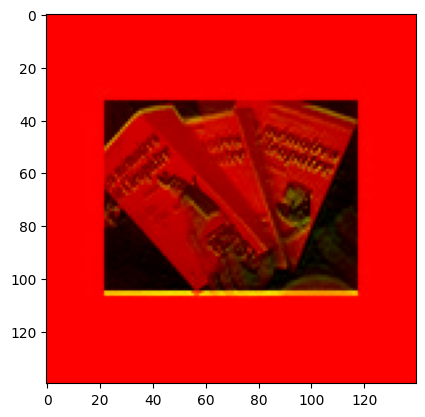

In [11]:
plt.imshow(Xprim[2])
plt.savefig('pictureXprimg.jpg')

In [83]:
'''
Y_df = pd.DataFrame(Y,columns=['col1'] )

Y_df = Y_df.replace(to_replace = np.unique(Y), value = range(len(np.unique(Y))))


Y = Y_df.to_numpy()
Y = Y[:,0]
'''


In [12]:
labelencoder = preprocessing.LabelEncoder()

Y_encoded = labelencoder.fit_transform(Y)

# Y = labelencoder.inverse_transform(Y_encoded)

In [72]:
np.unique(Y_encoded)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int64)

In [13]:
# On split le jeu d'entrainement et le jeu de test
X_train, X_test, y_train, y_test = train_test_split(Xprim, Y_encoded, test_size = .2, random_state = 42, shuffle = True)


In [74]:
print(y_train.shape)
print(X_train.shape)

(3396,)
(3396, 140, 140, 3)


In [14]:

train_datagen = ImageDataGenerator(
    
    horizontal_flip = True
    ) # randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator()

batch_size = 128


train_dataset = train_datagen.flow(X_train,y_train,
                         batch_size = batch_size)


test_dataset = test_datagen.flow(X_test, y_test, batch_size = batch_size) 



In [11]:
y_train.shape

(3396, 27)

In [15]:
# réseau de neurone Lenet
inputs = Input(shape = (140, 140,3), name = "Input")


max_pool_1 = MaxPooling2D(pool_size = (2, 2))

conv_2 = Conv2D(filters = 16,                    
                kernel_size = (3, 3),          
                padding = 'valid',             
                activation = 'relu')

max_pool_2 = MaxPooling2D(pool_size = (2, 2))

flatten = Flatten()

dropout = Dropout(rate = 0.2)

dense_1 = Dense(units = 64,
                activation = 'relu')



output_layer = Dense(units = 27,
                activation = 'softmax')
#x=conv_1(inputs)
x=max_pool_1(inputs)
x=conv_2(x)
x=max_pool_2(x)


x=dropout(x)
x=flatten(x)
x=dense_1(x)

outputs=output_layer(x)
model = Model(inputs = inputs, outputs = outputs)

In [16]:
model.compile(loss='sparse_categorical_crossentropy', # fonction de perte
              optimizer='adam',                # algorithme d'optimisation
              metrics=['accuracy'])            # métrique d'évaluation



In [17]:
epochs = 100
training_history = model.fit_generator(
            train_dataset, # use augmented images for train 
            steps_per_epoch=X_train.shape[0] // batch_size,
            validation_data = test_dataset, # use augmented images for test
            epochs = epochs,
            )

C:\Users\MBACHKAT\AppData\Local\Temp\ipykernel_15348\1799996744.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  training_history = model.fit_generator(


Epoch 1/100
26/26 [==============================] - 5s 171ms/step - loss: 3.2631 - accuracy: 0.0958 - val_loss: 3.0370 - val_accuracy: 0.1518
Epoch 2/100
26/26 [==============================] - 4s 155ms/step - loss: 2.9916 - accuracy: 0.1652 - val_loss: 2.8840 - val_accuracy: 0.1988
Epoch 3/100
26/26 [==============================] - 4s 156ms/step - loss: 2.8539 - accuracy: 0.1958 - val_loss: 2.8041 - val_accuracy: 0.2459
Epoch 4/100
26/26 [==============================] - 5s 204ms/step - loss: 2.7315 - accuracy: 0.2353 - val_loss: 2.7477 - val_accuracy: 0.2376
Epoch 5/100
26/26 [==============================] - 6s 219ms/step - loss: 2.6459 - accuracy: 0.2613 - val_loss: 2.7154 - val_accuracy: 0.2518
Epoch 6/100
26/26 [==============================] - 5s 201ms/step - loss: 2.5594 - accuracy: 0.2870 - val_loss: 2.6761 - val_accuracy: 0.2659
Epoch 7/100
26/26 [==============================] - 5s 202ms/step - loss: 2.4599 - accuracy: 0.3140 - val_loss: 2.6351 - val_accuracy: 0.2741

In [18]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

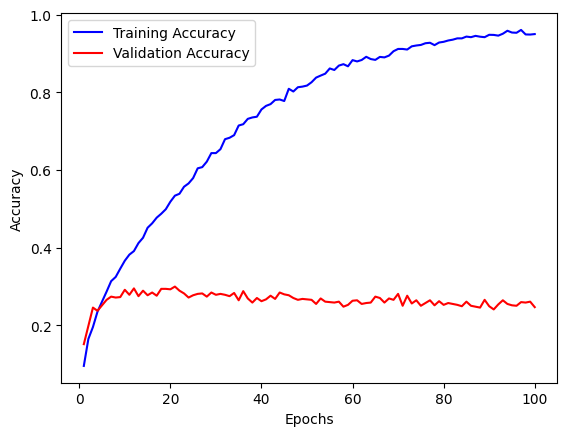

In [19]:
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 101, 1),
         training_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 , 101, 1),
         training_history.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()
plt.savefig('accuracyideag.jpg')
# Affichage de la figure
plt.show()
